In [176]:
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# crack the datasets 
df_2021 = pd.read_excel('data/Audatex_Claims.Updated(2021).xlsx')
df_2022 = pd.read_excel('data/Audatex_Claims.Updated(2022).xlsx')
df_2023 = pd.read_excel('data/Audatex_Claims.Updated(2023).xlsx')

# merging datasets with year identifier
df_2021['year'] = 2021
df_2022['year'] = 2022
df_2023['year'] = 2023
df_combined = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)

df_combined.head(10)

,CREATIONDATE,ASSESSMENTNUMBER,ORIGINATOR,CLAIMREFERENCENUMBER,CLAIMNUMBER,WORKPROVIDER,BROKER,CALCULATIONDATE,MANUFACTURERNAME,MODELNAME,...,STEERINGCONDITION,BRAKES,IMPACTSOURCE,IMPACTDES,JDENUMBER,SITEID,Insurer,Month,Year,year
0,2021-04-26 09:58:43,A0000001,BRITSAUB,20275738301700043,202757383,Santam Insurance Company,"Du Preez HA,",2021-05-24 08:15:00,TOYOTA,L Cruiser 200,...,Not testable,Not testable,B Right Hand Front,C Right Hand Side,110533,2008.0,Other,2021-04-30,2021,2021
1,2021-03-03 08:49:10,A0000003,SANTAMTR,20391297801700022,203912978,Santam Insurance Company,MOMENTUM CONSULT PTY LTD,2021-03-17 12:07:00,TOYOTA,Rav 4,...,Not testable,Not testable,E Centre Rear,A Centre Front,17223337,2017.0,Other,2021-03-31,2021,2021
2,2021-05-04 09:21:27,A0000011,SANTAMTR,20278287601700007,202782876,Santam Insurance Company,T AND C WERNER BROKERS,2021-05-27 08:42:00,VOLVO,XC60,...,Not testable,Not testable,A Centre Front,E Centre Rear,6824060,2017.0,Other,2021-05-31,2021,2021
3,2021-01-12 10:50:02,A0000104,SANTPTA1,20223820300400003,202238203,Santam Insurance Company,BESTONIA MAKELAARS,2021-02-08 06:31:00,TOYOTA,Hi-lux,...,Not testable,Not testable,A Centre Front,E Centre Rear,26324236,2012.0,Other,2021-01-31,2021,2021
4,2021-01-20 10:53:04,A0000105,SANTPTA1,20261741700400990,202617417,Santam Insurance Company,MIDDEL AND PARTNERS INSURANCE BROKERS CC,2021-02-10 13:04:00,TOYOTA,RunX,...,Not testable,Not testable,C Right Hand Side,G Left Hand Side,21105553,2006.0,Other,2021-01-31,2021,2021
5,2021-06-10 07:47:03,A0000111,SANTAMTR,20382540400400997,203825404,Santam Insurance Company,Wilkinson Insurance Brokers (Pty) Ltd,2021-12-17 14:40:00,RENAULT,Clio IV,...,Satisfactory,Satisfactory,B Right Hand Front,F Left Hand Rear,26711036,2016.0,Other,2021-06-30,2021,2021
6,2021-03-08 10:25:05,A0000125,SANTPTA1,20281102700400994,202811027,Santam Insurance Company,SANTAM DIRECT BUSINESS,2021-05-21 11:45:00,VOLKSWAGEN,Transporter T6,...,Not testable,Not testable,F Left Hand Rear,H Left Hand Front,109356,2019.0,Other,2021-03-31,2021,2021
7,2021-03-12 06:35:30,A0000126,SANTPTA1,20271656300400996,202716563,Santam Insurance Company,0,2021-04-08 09:21:00,VOLKSWAGEN,Polo,...,Satisfactory,Satisfactory,A Centre Front,E Centre Rear,0,2016.0,Other,2021-03-31,2021,2021
8,2021-04-13 14:38:20,A0000128,SANTPTA1,20280766600400993,202807666,Santam Insurance Company,0,2021-07-30 06:12:00,TATA,Ace/Super Ace,...,Not testable,Not testable,D Right Hand Rear,C Right Hand Side,123414,2017.0,Other,2021-04-30,2021,2021
9,2021-04-15 12:42:41,A0000129,SANTPTA1,20106683200400002,201066832,Santam Insurance Company,0,2021-06-08 15:14:00,CHEVROLET,Chevrolet Utility,...,Satisfactory,Satisfactory,B Right Hand Front,C Right Hand Side,26324236,2013.0,Other,2021-04-30,2021,2021


In [178]:
# basic exploration
print(df_combined.info())  # check data types and missing values
print(df_combined['TOTALCOSTOFCLAIM'].describe())  # summary stats for target
print(df_combined.isnull().sum())  # check missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256679 entries, 0 to 256678
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CREATIONDATE             256679 non-null  datetime64[ns]
 1   ASSESSMENTNUMBER         256679 non-null  object        
 2   ORIGINATOR               256679 non-null  object        
 3   CLAIMREFERENCENUMBER     256678 non-null  object        
 4   CLAIMNUMBER              256678 non-null  object        
 5   WORKPROVIDER             256679 non-null  object        
 6   BROKER                   234875 non-null  object        
 7   CALCULATIONDATE          256679 non-null  datetime64[ns]
 8   MANUFACTURERNAME         256679 non-null  object        
 9   MODELNAME                256679 non-null  object        
 10  SUBMODELTEXT             255563 non-null  object        
 11  YEARREG                  255633 non-null  float64       
 12  MONTHREG        

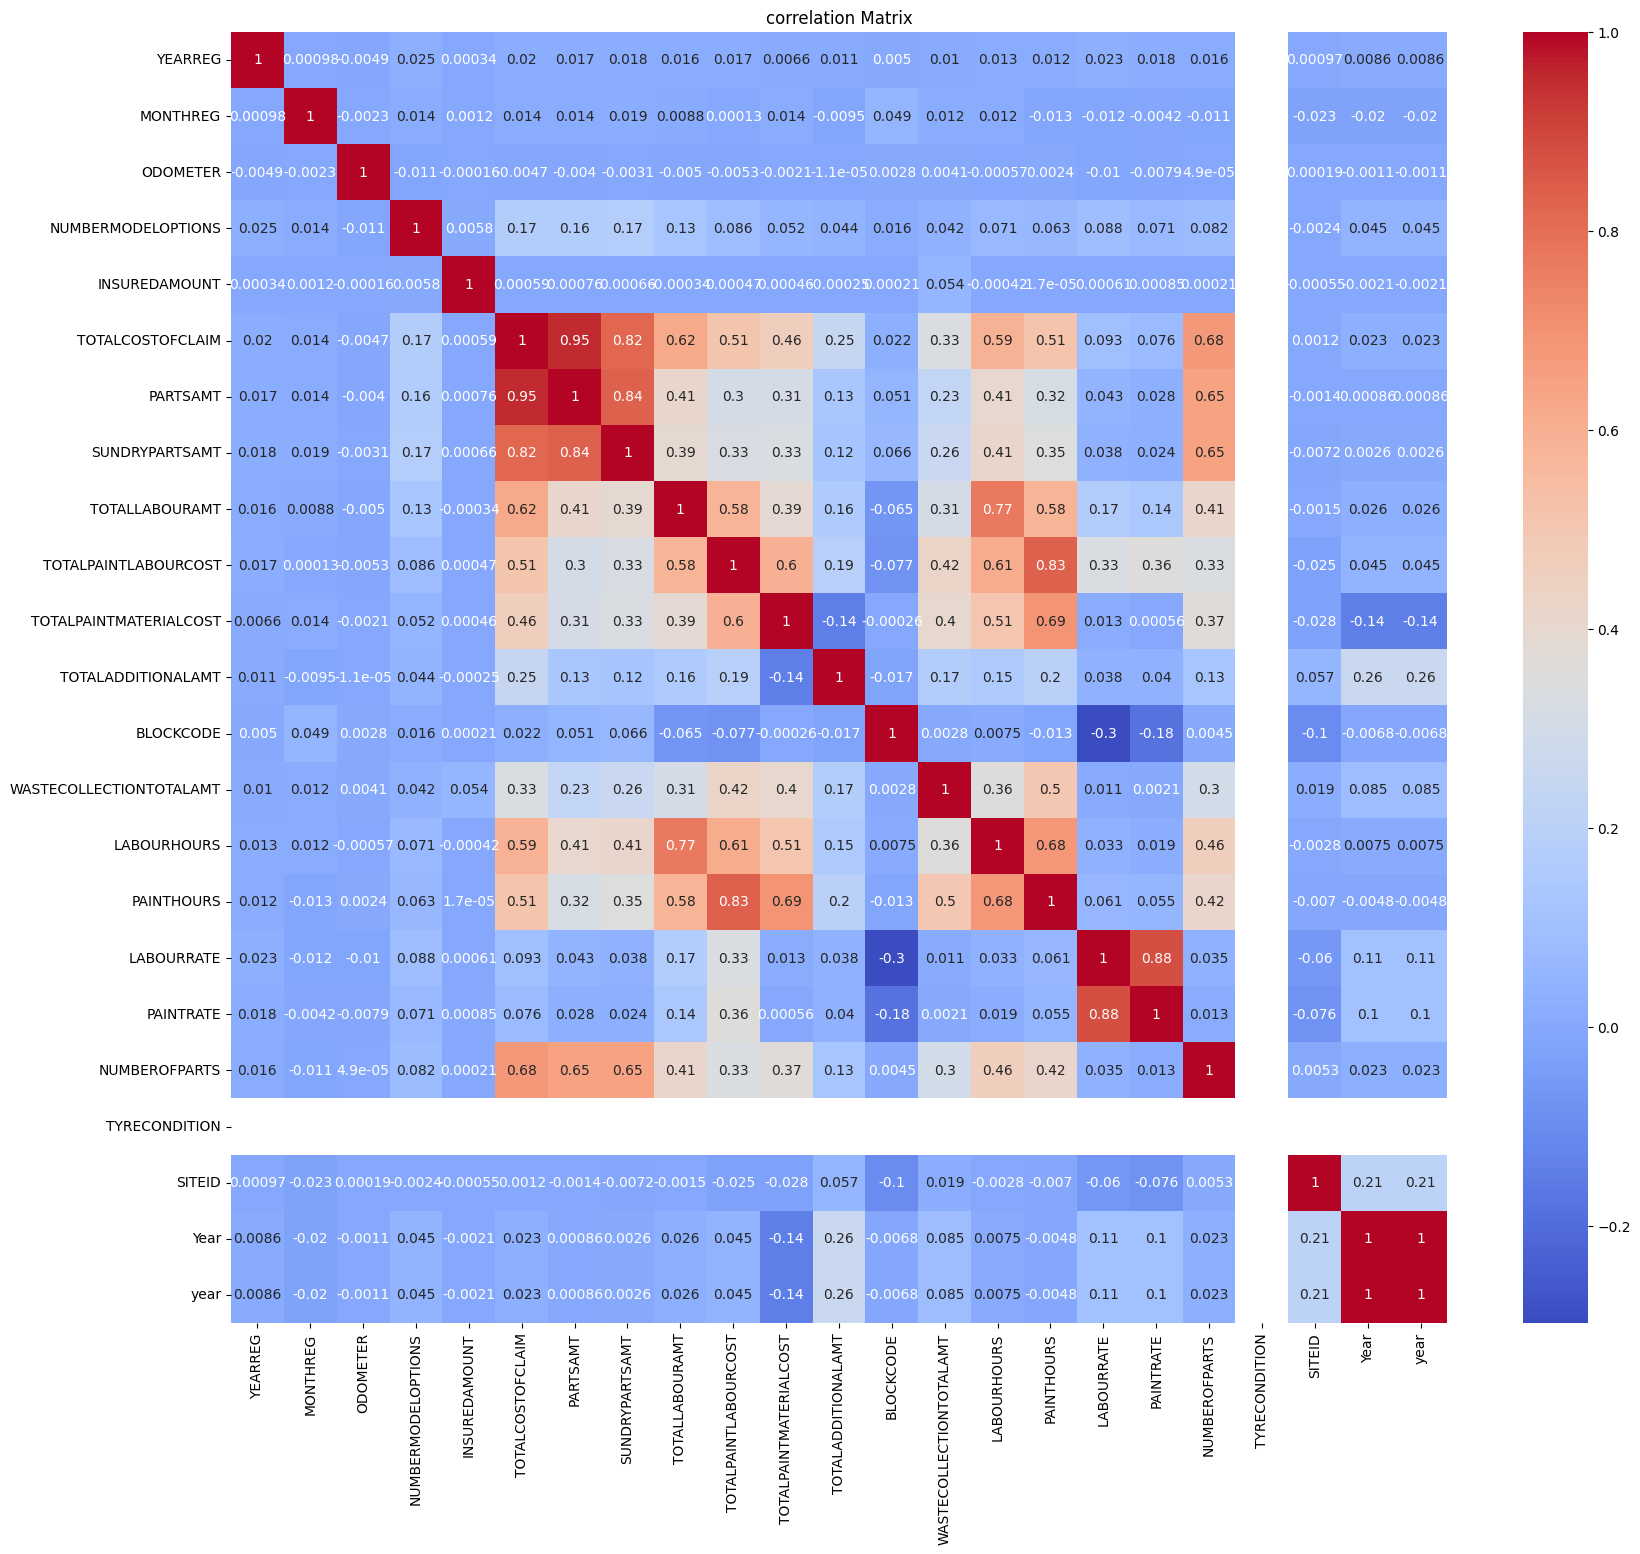

In [179]:

# correlation with numerical features
numerical_cols = df_combined.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df_combined[numerical_cols].corr(), annot=True, cmap='coolwarm')
pl.title('correlation Matrix')
pl.subplots_adjust(right=2.5, top=2.8)
pl.show()

/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/834145792.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  odometer_cost = df_combined.groupby(['ODOMETER_BIN', 'year'])['TOTALCOSTOFCLAIM'].mean().unstack()
/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/834145792.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DAMAGESEVERITY', y='TOTALCOSTOFCLAIM', hue='year', data=df_combined, estimator=np.mean, ci=None, ax=axes[1, 1])
/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/834145792.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation

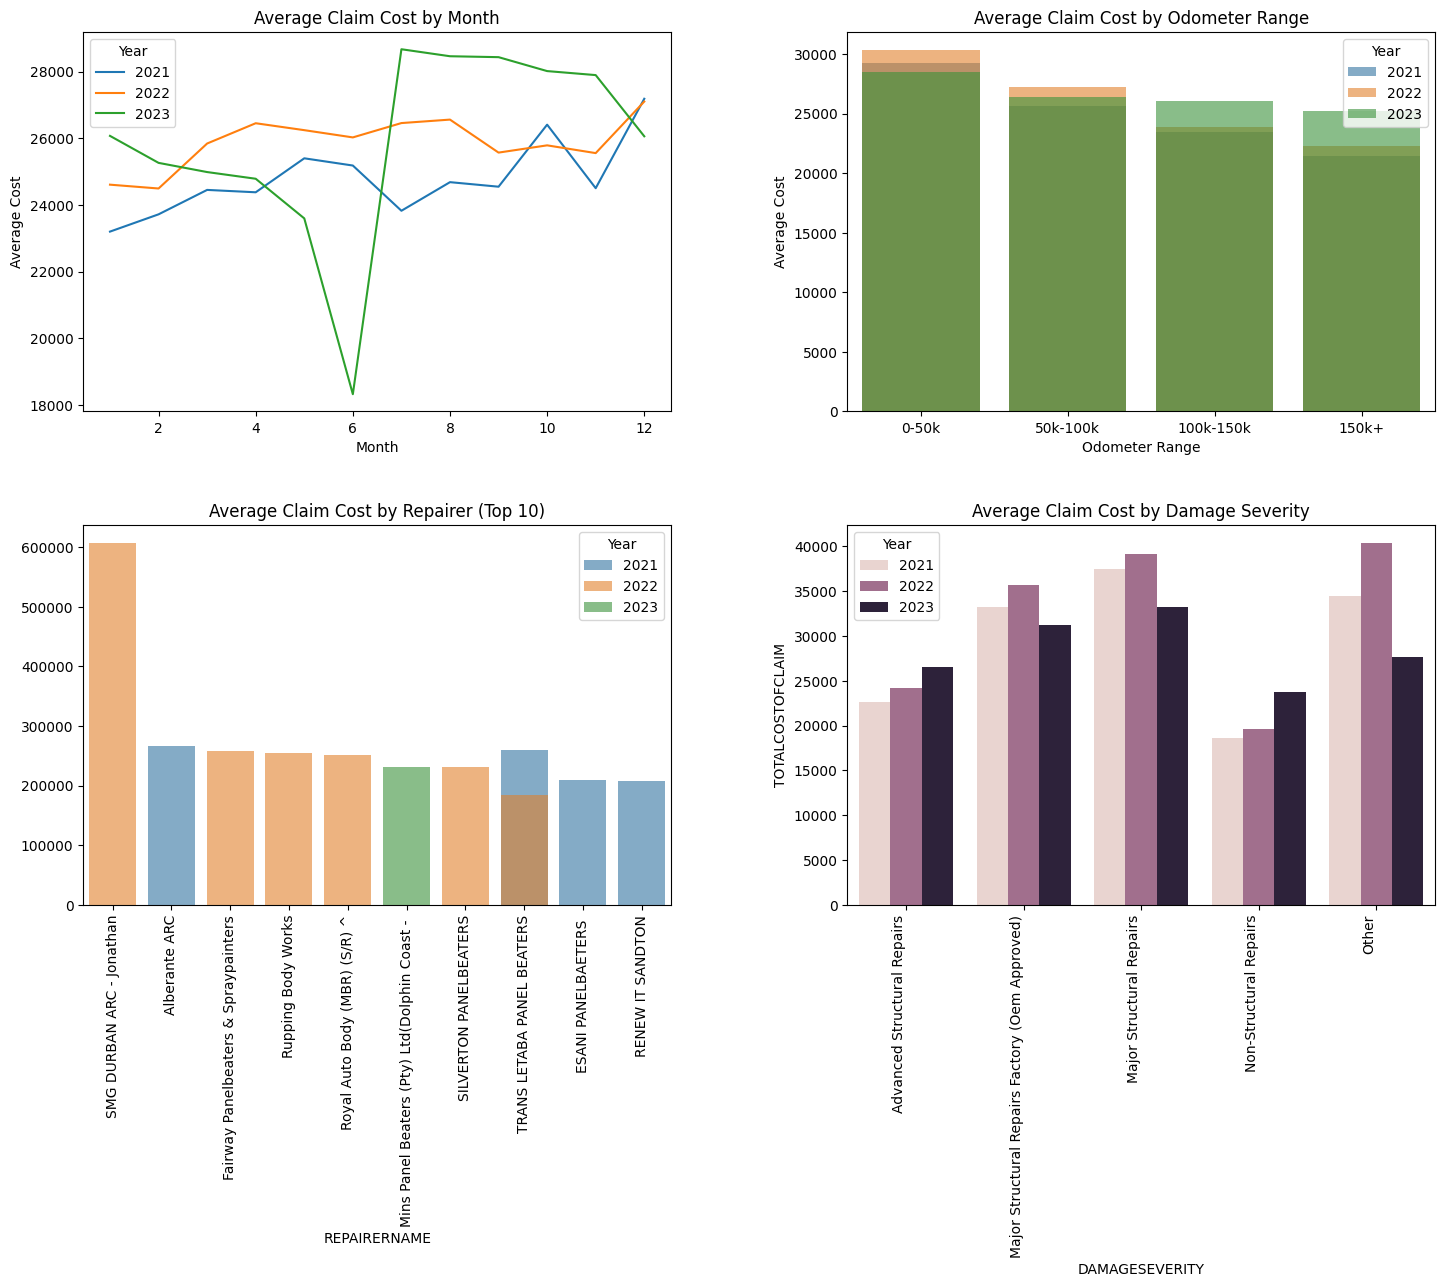

In [180]:
df_combined['CREATIONDATE'] = pd.to_datetime(df_combined['CREATIONDATE'])
df_combined['CALCULATIONDATE'] = pd.to_datetime(df_combined['CALCULATIONDATE'])
df_combined['creation_year'] = df_combined['CREATIONDATE'].dt.year
df_combined['creation_month'] = df_combined['CREATIONDATE'].dt.month
df_combined['creation_day'] = df_combined['CREATIONDATE'].dt.day
df_combined['time_diff_days'] = (df_combined['CALCULATIONDATE'] - df_combined['CREATIONDATE']).dt.days


df_combined['ODOMETER_BIN'] = pd.cut(df_combined['ODOMETER'], bins=[0, 50000, 100000, 150000, float('inf')], 
                                     labels=['0-50k', '50k-100k', '100k-150k', '150k+'])

monthly_cost = df_combined.groupby(['creation_month', 'year'])['TOTALCOSTOFCLAIM'].mean().unstack()
severity_cost = df_combined.groupby(['DAMAGESEVERITY', 'year'])['TOTALCOSTOFCLAIM'].agg(['mean', 'count']).unstack()
repairer_cost = df_combined.groupby(['REPAIRERNAME', 'year'])['TOTALCOSTOFCLAIM'].mean().unstack()
odometer_cost = df_combined.groupby(['ODOMETER_BIN', 'year'])['TOTALCOSTOFCLAIM'].mean().unstack()

# print("Severity Cost Summary (Mean, Count) by Year:")
# print(severity_cost)
# print("\nTop 10 Repairer Costs by Year:")
# print(repairer_cost.head(10))

fig, axes = pl.subplots(2, 2, figsize=(9, 7))
fig.tight_layout(pad=4.0)

for year in monthly_cost.columns:
    sns.lineplot(x=monthly_cost.index, y=monthly_cost[year], ax=axes[0, 0], label=str(year))
axes[0, 0].set_title('Average Claim Cost by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Cost')
axes[0, 0].legend(title='Year')

sns.barplot(x='DAMAGESEVERITY', y='TOTALCOSTOFCLAIM', hue='year', data=df_combined, estimator=np.mean, ci=None, ax=axes[1, 1])
axes[1, 1].set_title('Average Claim Cost by Damage Severity')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90, ha='right')
axes[1, 1].legend(title='Year')

top_repairers = repairer_cost.mean(axis=1).nlargest(10).index
for year in repairer_cost.columns:
    sns.barplot(x=repairer_cost.loc[top_repairers, year].index, y=repairer_cost.loc[top_repairers, year].values, 
                ax=axes[1, 0], label=str(year), alpha=0.6)
axes[1, 0].set_title('Average Claim Cost by Repairer (Top 10)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
axes[1, 0].legend(title='Year')

for year in odometer_cost.columns:
    sns.barplot(x=odometer_cost.index, y=odometer_cost[year], ax=axes[0, 1], label=str(year), alpha=0.6)
axes[0, 1].set_title('Average Claim Cost by Odometer Range')
axes[0, 1].set_xlabel('Odometer Range')
axes[0, 1].set_ylabel('Average Cost')
axes[0, 1].legend(title='Year')

pl.tight_layout()
pl.subplots_adjust(right=1.6, top=1.8, hspace=0.3, wspace=0.3)
pl.show()

/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/421505697.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='RdYlBu_r')


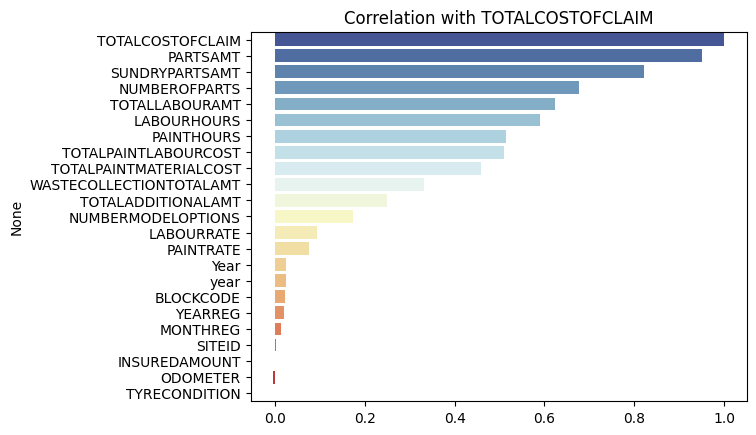

In [181]:
correlations = df_combined[numerical_cols].corrwith(df_combined['TOTALCOSTOFCLAIM']).sort_values(ascending=False)
sns.barplot(x=correlations.values, y=correlations.index, palette='RdYlBu_r')
pl.title('Correlation with TOTALCOSTOFCLAIM')
pl.show()

In [182]:
numerical_cols = df_combined.select_dtypes(include=['float64', 'int64']).columns
correlations = df_combined[numerical_cols].corrwith(df_combined['TOTALCOSTOFCLAIM']).sort_values(ascending=False)
threshold = 0.3
influential_cols = correlations[abs(correlations) > threshold].index.tolist()
if 'TOTALCOSTOFCLAIM' not in influential_cols:
    influential_cols.append('TOTALCOSTOFCLAIM')
df_filtered = df_combined[influential_cols]

/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/xola/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [183]:
# handle missing values
numerical_cols_filtered = df_filtered.select_dtypes(include=['float64', 'int64']).columns.drop('TOTALCOSTOFCLAIM')
df_filtered[numerical_cols_filtered] = df_filtered[numerical_cols_filtered].fillna(df_filtered[numerical_cols_filtered].median())
categorical_cols_filtered = df_filtered.select_dtypes(include=['object']).columns
for col in categorical_cols_filtered:
    df_filtered[col] = df_filtered[col].fillna('Unknown')


/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/3447228584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[numerical_cols_filtered] = df_filtered[numerical_cols_filtered].fillna(df_filtered[numerical_cols_filtered].median())


In [ ]:
# outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.65 * IQR
    upper_bound = Q3 + 1.65 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numerical_cols_filtered:
    original_len = len(df_filtered)
    df_filtered = remove_outliers(df_filtered, col)
    print(f"removed {original_len - len(df_filtered)} outliers from {col}")
print(f"new dataset shape: {df_filtered.shape}")

removed 19819 outliers from PARTSAMT
removed 8709 outliers from SUNDRYPARTSAMT
removed 13903 outliers from NUMBEROFPARTS
removed 14864 outliers from TOTALLABOURAMT
removed 6094 outliers from LABOURHOURS
removed 6629 outliers from PAINTHOURS
removed 3514 outliers from TOTALPAINTLABOURCOST
removed 1008 outliers from TOTALPAINTMATERIALCOST
removed 22786 outliers from WASTECOLLECTIONTOTALAMT
new dataset shape: (159353, 10)


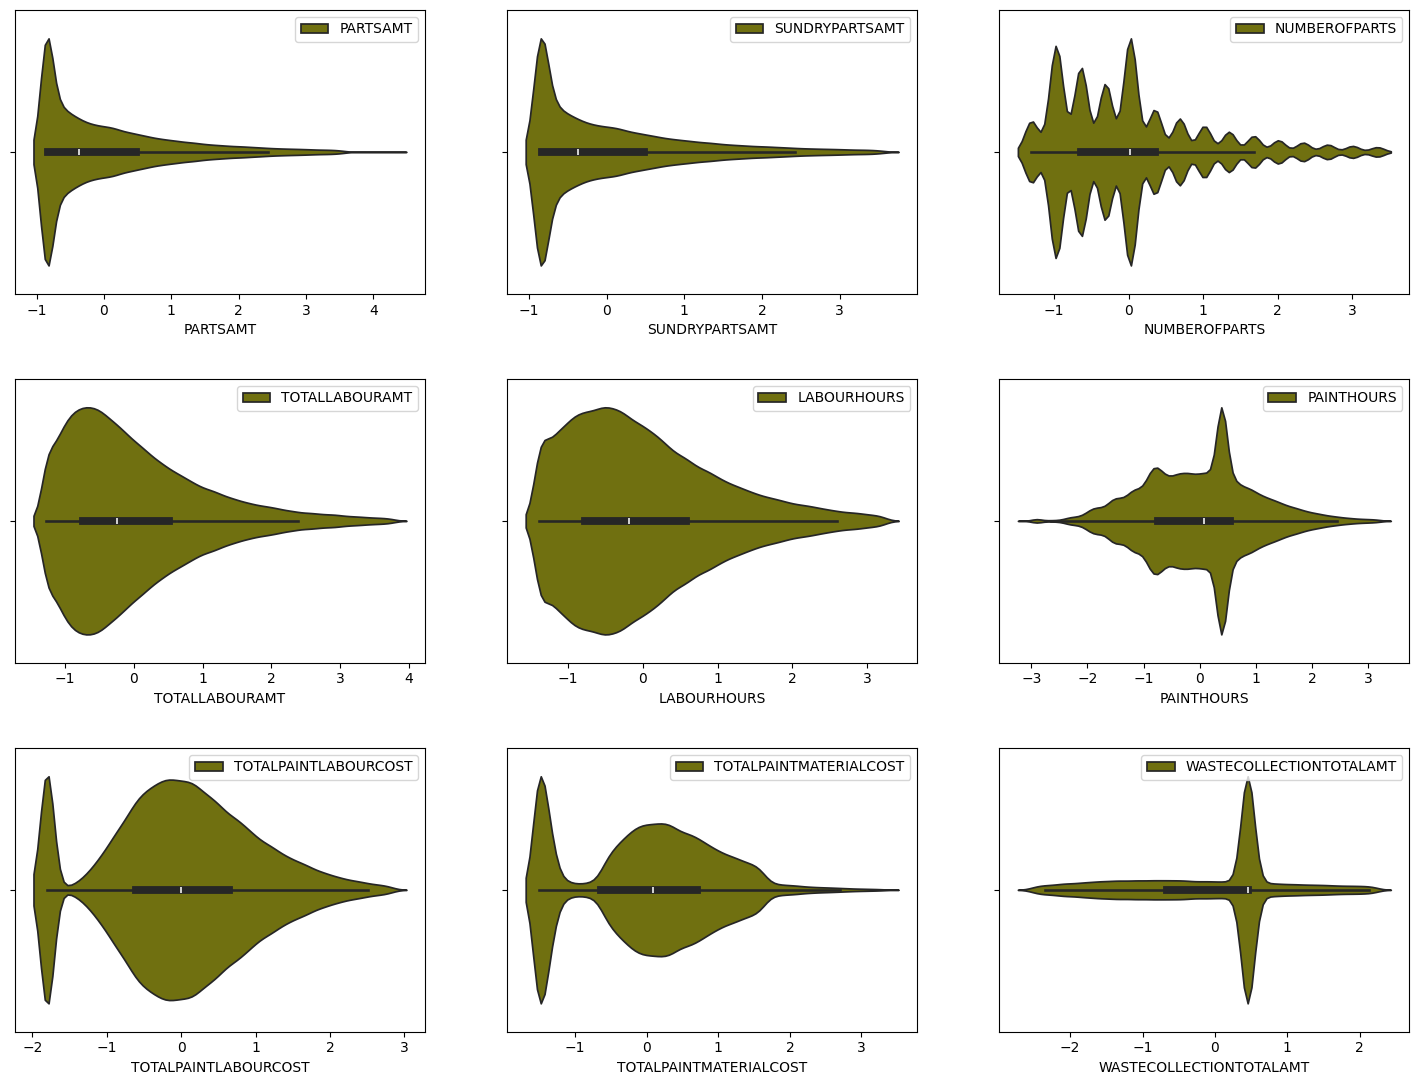

In [203]:
# filter numerical columns for outlier visualization
numerical_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('TOTALCOSTOFCLAIM') # remove target var

# create subplots for numerical columns only
n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # rows

fig, ax = pl.subplots(nrows=n_rows, ncols=n_cols, figsize=(9, n_rows * 2))
ax = ax.flatten() 

for i, col in enumerate(numerical_cols):
    sns.violinplot(x=df_filtered[col], orient='h', ax=ax[i], label=col, color='olive')

# remove empty subplots if any
for i in range(len(numerical_cols), len(ax)):
    fig.delaxes(ax[i])

pl.tight_layout()
pl.subplots_adjust(right=1.6, top=1.8, hspace=0.3, wspace=0.2)
pl.show()


Unique manufacturer names after standardization:
['Toyota' 'Volvo' 'Renault' 'Volkswagen' 'Tata' 'Chevrolet' 'Ford' 'Bmw'
 'Datsun' 'Mercedes Benz' 'Hyundai' 'Peugeot' 'Isuzu' 'Mazda' 'Nissan'
 'Kia' 'Chev/Daewoo' 'Honda' 'Audi' 'Land Rover' 'Daihatsu'
 'Chrysler/Jeep' 'Opel' 'Dodge' 'Suzuki' 'Mitsubishi' 'Jaguar' 'Haval'
 'Subaru' 'Maserati' 'Lexus' 'Gwm' 'Mini' 'Mahindra' 'Fiat' 'Porsche'
 'Alfa Romeo' 'Universal' 'Citroen' 'Smart' 'Infiniti' 'Chana Changan'
 'Chery' 'Bentley' 'Jmc' 'Ssangyong' 'Hafei' 'Seat' 'Faw' 'Cadillac']


/var/folders/3d/y9v02zfn3jx0vssyx0tpsj000000gn/T/ipykernel_97727/2766235710.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=manufacturer_cost_top.values, y=manufacturer_cost_top.index, orient='h', palette='RdYlBu_r')


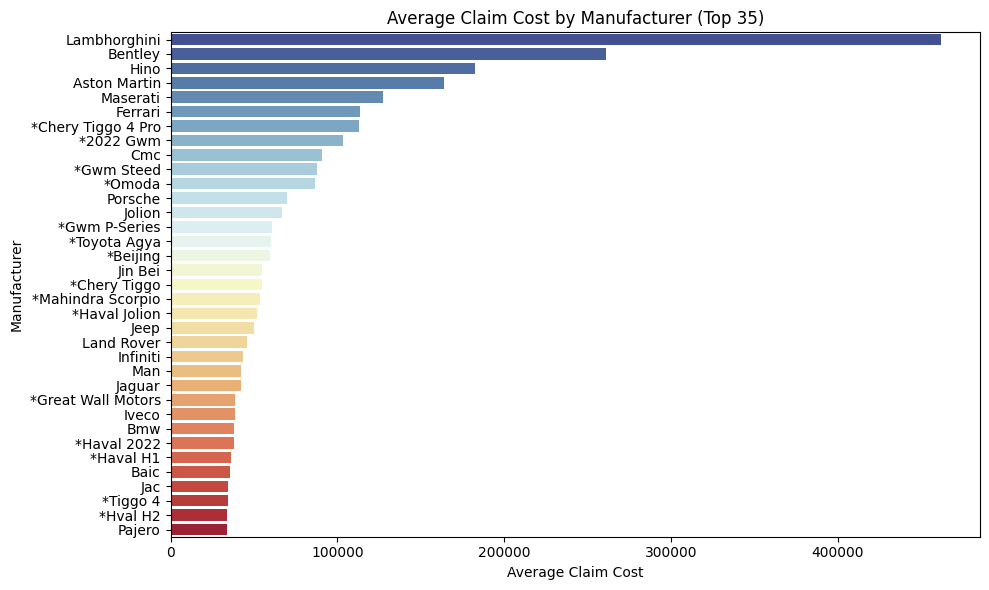

In [186]:

from fuzzywuzzy import fuzz
from collections import defaultdict

def standardize_manufacturer(name):
    if pd.isna(name):  
        return 'Unknown'
    name = str(name).strip().title()
    name = name.replace('  ', ' ') 
    return name

df_combined['MANUFACTURERNAME'] = df_combined['MANUFACTURERNAME'].apply(standardize_manufacturer)


manufacturer_map = {}
seen_names = defaultdict(list)

for name in df_combined['MANUFACTURERNAME'].dropna().unique():
    matched = False
    for standard_name, variants in seen_names.items():
        if any(fuzz.ratio(name, variant) > 85 for variant in variants):  # Threshold 85%
            seen_names[standard_name].append(name)
            manufacturer_map[name] = standard_name
            matched = True
            break
    if not matched:
        seen_names[name].append(name)
        manufacturer_map[name] = name

df_combined['MANUFACTURERNAME'] = df_combined['MANUFACTURERNAME'].map(lambda x: manufacturer_map.get(x, x))

print("\nUnique manufacturer names after standardization:")
print(df_combined['MANUFACTURERNAME'].unique()[:50])

manufacturer_cost = df_combined.groupby('MANUFACTURERNAME')['TOTALCOSTOFCLAIM'].mean().sort_values(ascending=False)

top_n = 35
manufacturer_cost_top = manufacturer_cost.head(top_n)

pl.figure(figsize=(10, 6))
sns.barplot(x=manufacturer_cost_top.values, y=manufacturer_cost_top.index, orient='h', palette='RdYlBu_r')

pl.title('Average Claim Cost by Manufacturer (Top 35)')
pl.xlabel('Average Claim Cost')
pl.ylabel('Manufacturer')

# for i, v in enumerate(manufacturer_cost_top.values):
#     pl.text(v + 10, i, f'{v:.2f}', va='center', color='black')

# Adjust layout to prevent label overlap
pl.tight_layout()
pl.show()

In [187]:
print(df_filtered.isnull().sum())  # check missing values

TOTALCOSTOFCLAIM           1
PARTSAMT                   0
SUNDRYPARTSAMT             0
NUMBEROFPARTS              0
TOTALLABOURAMT             0
LABOURHOURS                0
PAINTHOURS                 0
TOTALPAINTLABOURCOST       0
TOTALPAINTMATERIALCOST     0
WASTECOLLECTIONTOTALAMT    0
dtype: int64


In [188]:
df_filtered = df_filtered.dropna(subset=['TOTALCOSTOFCLAIM'])
print(df_filtered.isnull().sum())

TOTALCOSTOFCLAIM           0
PARTSAMT                   0
SUNDRYPARTSAMT             0
NUMBEROFPARTS              0
TOTALLABOURAMT             0
LABOURHOURS                0
PAINTHOURS                 0
TOTALPAINTLABOURCOST       0
TOTALPAINTMATERIALCOST     0
WASTECOLLECTIONTOTALAMT    0
dtype: int64


### $\texttt{rf regressor}$

In [191]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

for col in categorical_cols_filtered:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))

scaler = StandardScaler()
df_filtered[numerical_cols_filtered] = scaler.fit_transform(df_filtered[numerical_cols_filtered])

X = df_filtered.drop('TOTALCOSTOFCLAIM', axis=1)
y = np.log1p(df_filtered['TOTALCOSTOFCLAIM'])  # Log transform the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

rf = RandomForestRegressor(random_state=50)
rf.fit(X_train, y_train)
print(f"\n done training \n")
y_pred = rf.predict(X_test)
y_pred_original = np.expm1(y_pred)  
y_test_original = np.expm1(y_test)  # reverse log transformation

print(f"\n attempting to calculate scores\n")

# check model score with cross-vals
# cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
# cv_rmse = np.sqrt(-cv_scores.mean())
# cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2').mean()

print(f"\n\n train-Test Split RMSE (original scale): {np.sqrt(mean_squared_error(y_test_original, y_pred_original)):.2f}\n\n")
print(f"\n\n train-Test Split R² (original scale): {r2_score(y_test_original, y_pred_original):.2f}\n\n")
# print(f"\n\n cross-Validation RMSE (log scale): {cv_rmse:.2f}\n\n")
# print(f"\n\n cross-Validation R² (log scale): {cv_r2:.2f}\n\n")


 done training 


 attempting to calculate scores



 train-Test Split RMSE (original scale): 4123.54




 train-Test Split R² (original scale): 0.81




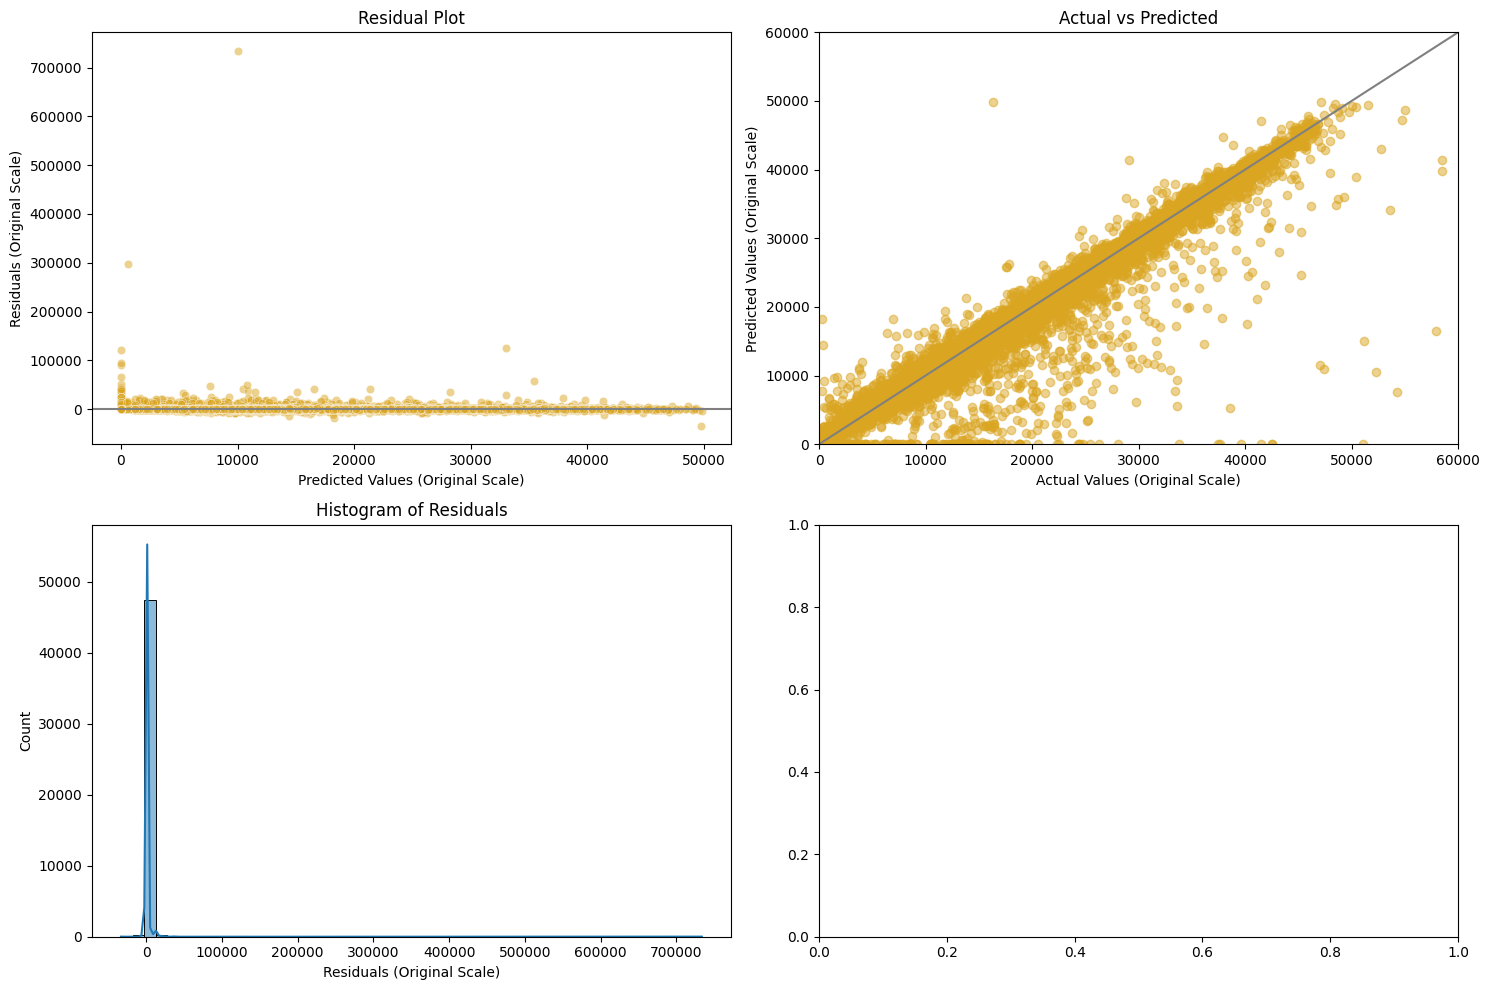

In [195]:
residuals_original = y_test_original - y_pred_original

fig, axes = pl.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x=y_pred_original, y=residuals_original, alpha=0.5, color='goldenrod', ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='grey', linestyle='-')
axes[0, 0].set_xlabel('Predicted Values (Original Scale)')
axes[0, 0].set_ylabel('Residuals (Original Scale)')
axes[0, 0].set_title('Residual Plot')



axes[0, 1].scatter(y_test_original, y_pred_original, alpha=0.5, color='goldenrod')
axes[0, 1].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 
                color='grey', linestyle='-')
axes[0, 1].set_xlabel('Actual Values (Original Scale)')
axes[0, 1].set_ylabel('Predicted Values (Original Scale)')
axes[0, 1].set_title('Actual vs Predicted')
axes[0, 1].set_xlim([-10, 60000])
axes[0, 1].set_ylim([-10, 60000])

sns.histplot(residuals_original, bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals (Original Scale)')
axes[1, 0].set_title('Histogram of Residuals')

pl.tight_layout()
pl.show()

### $\texttt{XGBRegressor}$

In [199]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor(random_state=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_original = np.expm1(y_pred)  
y_test_original = np.expm1(y_test)  # reverse log transformation

print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"XGBoost R²: {r2_score(y_test, y_pred)}")

XGBoost RMSE: 0.4630905674031715
XGBoost R²: 0.9183488744270573


AttributeError: Rectangle.set() got an unexpected keyword argument 'density'

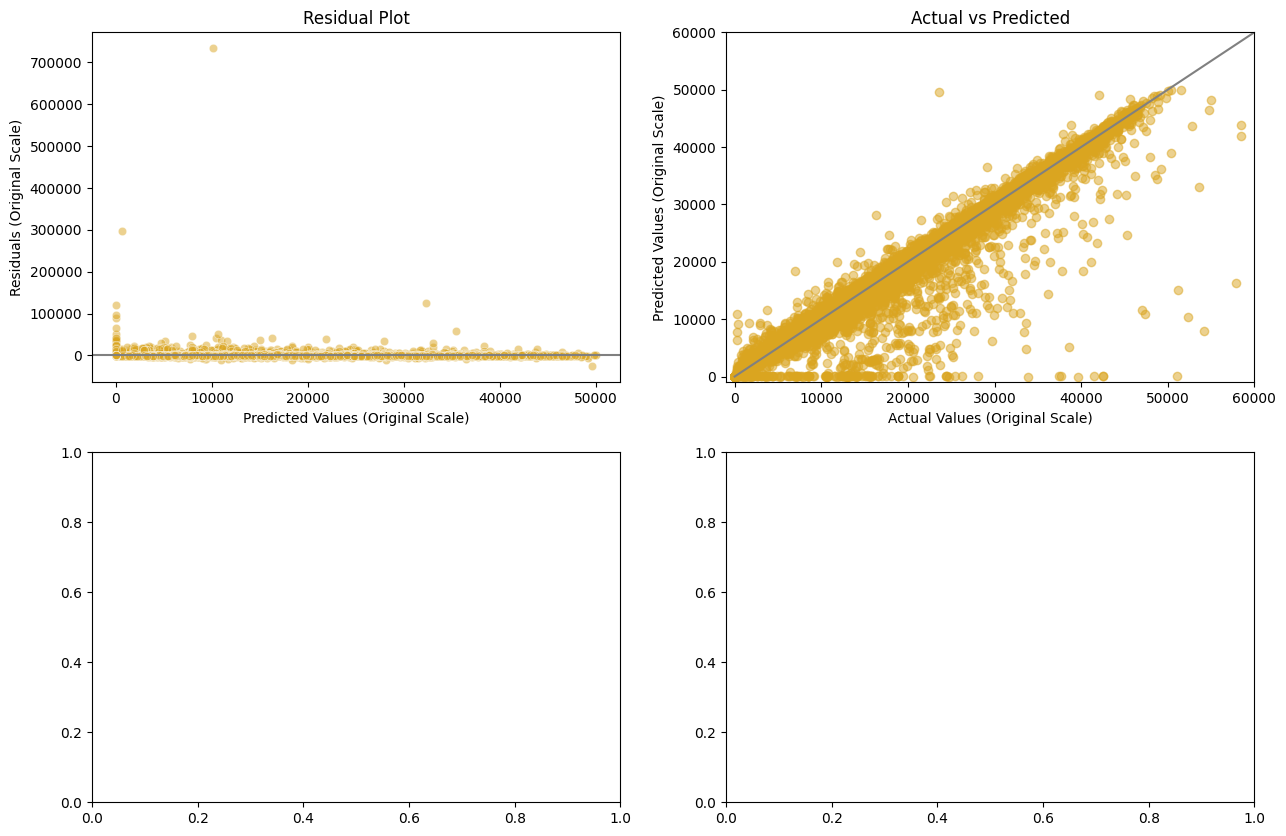

In [ ]:
residuals_original = y_test_original - y_pred_original

fig, axes = pl.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x=y_pred_original, y=residuals_original, alpha=0.5, color='goldenrod', ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='grey', linestyle='-')
axes[0, 0].set_xlabel('Predicted Values (Original Scale)')
axes[0, 0].set_ylabel('Residuals (Original Scale)')
axes[0, 0].set_title('Residual Plot')



axes[0, 1].scatter(y_test_original, y_pred_original, alpha=0.5, color='goldenrod')
axes[0, 1].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 
                color='grey', linestyle='-')
axes[0, 1].set_xlabel('Actual Values (Original Scale)')
axes[0, 1].set_ylabel('Predicted Values (Original Scale)')
axes[0, 1].set_title('Actual vs Predicted')
axes[0, 1].set_xlim([-1000, 60000])
axes[0, 1].set_ylim([-1000, 60000])

sns.histplot(residuals_original, bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals (Original Scale)')
axes[1, 0].set_title('Histogram of Residuals')

pl.tight_layout()
pl.show()

### $\texttt{combine two models}$

In [201]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

estimators = [
    ('rf', RandomForestRegressor(random_state=50)),
    ('xgb', XGBRegressor(random_state=50)),
]
stack = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
y_pred_original = np.expm1(y_pred)  
y_test_original = np.expm1(y_test)  # reverse log transformation

print(f"Stacking RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"Stacking R²: {r2_score(y_test, y_pred)}")

Stacking RMSE: 0.46214513201468704
Stacking R²: 0.9186819283408122
